Y-DATA 2020/21<br/>
NLP HW5<br/>
Serge Tochilov

# Relation extraction

In this exercise, we are going to fine-tune a transformer model on a supervised **relation extraction** dataset.

Given a sentence, two entities of the sentence together with their contiguous character span within a sentence, the model will try to predict a relation between the entities.

For example, given the sentence *John, who played last night, is Doe's father*, and the info about the entities John and Doe, the model will try to predict a relation between John and Doe based on a set of pre-defined relations. In the above case the relation is "father $-$ son". Note that the relations may be either one-way or two-way.

The dataset we will use is a subset of the [TACRED](https://nlp.stanford.edu/projects/tacred/) dataset, a supervised relation extraction dataset by Stanford University.


The most straightforward supervised approach to the relation extraction problem is just to take one of the transformers and use the sentence and entities as input. However, in the present exercise we will try a different approach called **Question Answering (QA)**.

Instead of just using the entities and the sentence, we will train a model to answer the questions like *Who is the father of John?*, *Who is the son of Doe?*. If the model identifies them successfully, we will be able to conclude that the relation between the entities we ask for does exist.

In general, we will need to come up with the template question or questions **for each possible relation**. In the above example the template questions corresponding to "father $-$ son" relation:

*   Who is the father of {E1}?
*   Who is the child of {E2}?

where E1 and E2 are the entities.

## Exercise 1

Your task is to fine-tune a model for relation extraction using the question answering framework. There are several points to consider.

* In the previous lectures we run the demo notebook that demonstrated how to fine-tune a transformer on SQUAD, and technically **it's very similar** to what we need.
* For each of the seven relations in the TACRED dataset you need to find appropriate questions. Note that the questions must be SQUAD-like, i.e., if the corresponding answer exists it must be contiguous within the sentence.

There are several issues you need to solve by yourself. Please provide a brief explanation on how you tackled those issues.

## Data

Let's download the dataset hosted on Dropbox.

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/izi2x4sjohpzoot/relation_extraction_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Each dataframe row contain a news article and a sentence in which certain relationship (such as `invested_in`, or `founded_by`) was found. Particular patterns were used to gather the data, so it might contain some noise.

In [ ]:
import pandas as pd

df = pd.read_pickle("relation_extraction_dataset.pkl")
df.reset_index(drop=True, inplace=True)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12031 entries, 0 to 12030
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_idx           12031 non-null  object
 1   entities          12031 non-null  object
 2   entity_spans      12031 non-null  object
 3   match             12031 non-null  object
 4   original_article  12031 non-null  object
 5   sentence          12031 non-null  object
 6   start_idx         12031 non-null  object
 7   string_id         12031 non-null  object
dtypes: object(8)
memory usage: 752.1+ KB


,end_idx,entities,entity_spans,match,original_article,sentence,start_idx,string_id
0,1024,"[Lilium, Baillie Gifford]","[[3, 9], [151, 166]]",raising $35,Happy Friday!\n\nWe sincerely hope you and you...,"3) Lilium, a German startup that’s making an a...",1013,invested_in
1,1762,"[Facebook ’s, Giphy]","[[92, 102], [148, 153]]",acquisition,Happy Friday!\n\nWe sincerely hope you and you...,"Meanwhile, the UK’s watchdog on Friday announc...",1751,acquired_by
2,2784,"[Global-e, Vitruvian Partners]","[[27, 35], [94, 112]]",raised $60,Happy Friday!\n\nWe sincerely hope you and you...,Israeli e-commerce startup Global-e has raised...,2774,invested_in
3,680,"[Joris Van Der Gucht, Silverfin]","[[0, 19], [35, 44]]",founder,Hg is a leading investor in tax and accounting...,"Joris Van Der Gucht, co-founder at Silverfin c...",673,founded_by
4,2070,"[Tim Vandecasteele, Silverfin]","[[0, 17], [71, 80]]",founder,Hg is a leading investor in tax and accounting...,"Tim Vandecasteele, co-founder added: ""We want ...",2063,founded_by
5,3180,"[Hg, Silverfin]","[[0, 2], [39, 48]]",invested,Hg is a leading investor in tax and accounting...,Hg has invested in a minority stake in Silverf...,3172,invested_in
6,581,"[Joris Van Der Gucht, Silverfin]","[[0, 19], [35, 44]]",founder,Silverfin has secured a significant Series B i...,"Joris Van Der Gucht, co-founder at Silverfin, ...",574,founded_by
7,1939,"[Tim Vandecasteele, Silverfin]","[[0, 17], [71, 80]]",founder,Silverfin has secured a significant Series B i...,"Tim Vandecasteele, co-founder, adds: ""We want ...",1932,founded_by
8,3057,"[Hg, Silverfin]","[[0, 2], [39, 48]]",invested,Silverfin has secured a significant Series B i...,Hg has invested in a minority stake in Silverf...,3049,invested_in
9,2077,"[Felix Van de Maele, Collibra]","[[47, 65], [89, 97]]",founder,Brussels-basedÂ CollibraÂ provides data govern...,"It has become our most valuable asset,â said...",2070,founded_by


> ## Answer
For the present exercise we adapted the 🤗 "Question Answering with SQuAD 2.0" example from https://huggingface.co/transformers/custom_datasets.html#question-answering-with-squad-2-0.

> First we load a set of Python modules.

In [ ]:
! pip3 install spacy
! python3 -m spacy download en_core_web_trf

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.9 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 49.5 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 144 kB/s  eta 0:00:01
     |████████████████████████████████| 9.8 MB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 621 kB 42.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 70.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 100 kB 13.5 MB/s ta 0:00:01
     |████████████████████████████████| 82 kB 1.9 MB/s  eta 0:00:01
  Created wheel for contextvars: filename=contextvars-2.4-py3-none-any.whl size=7680 sha256=2bb0350cb65c4e28f1c270ab533645b7eb68481008e3ac6c677e092a526aabe1
  Stored in directory: /home/ubuntu/.cache/pip/wheels/41/11/53/911724983aa48deb

In [ ]:
from IPython.display import display
import numpy as np
import spacy, torch
from tqdm import notebook
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering, AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

> Get a list of relations.

In [ ]:
df['string_id'].value_counts()

founded_by       3593
acquired_by      2552
invested_in      2441
CEO_of           1665
subsidiary_of     800
partners_with     595
owned_by          385
Name: string_id, dtype: int64

> `invested_in` relation deserves a closer look.

In [ ]:
display(df[df['string_id'] == 'invested_in']['match'].value_counts().head(50))

invested                426
invest                  236
investment in           234
round led by            197
investing               188
invests                  72
in funding               71
seed round               66
seed funding             55
investors include        46
also participated in     25
round was led by         17
raised $100              16
raised $40               15
raised $10               14
series C                 13
series B                 13
raised $200              13
raised $60               11
raised $15               11
raised $2                11
raised $4                11
raised $25               10
raised $5                10
raised $20               10
raised $30               10
raised $160               9
raised $300               9
raised $50                9
raised $11                7
raised $110               7
raised $3                 7
raised $35                7
Investment in             7
raised $80                7
raised $400         

> We see that the `invested_in` relation is two-way actually, and its reverse is well-defined as `raised_from` by a set of keywords. Therefore, we create a separate relation for it.

In [ ]:
df['string_id_corr'] = df['string_id']
df.loc[df['match'].str.lower().str.contains('rais|secur|seed|close|led|series', regex=True), 'string_id_corr'] = 'raised_from'
df.head(10)

,end_idx,entities,entity_spans,match,original_article,sentence,start_idx,string_id,string_id_corr
0,1024,"[Lilium, Baillie Gifford]","[[3, 9], [151, 166]]",raising $35,Happy Friday!\n\nWe sincerely hope you and you...,"3) Lilium, a German startup that’s making an a...",1013,invested_in,raised_from
1,1762,"[Facebook ’s, Giphy]","[[92, 102], [148, 153]]",acquisition,Happy Friday!\n\nWe sincerely hope you and you...,"Meanwhile, the UK’s watchdog on Friday announc...",1751,acquired_by,acquired_by
2,2784,"[Global-e, Vitruvian Partners]","[[27, 35], [94, 112]]",raised $60,Happy Friday!\n\nWe sincerely hope you and you...,Israeli e-commerce startup Global-e has raised...,2774,invested_in,raised_from
3,680,"[Joris Van Der Gucht, Silverfin]","[[0, 19], [35, 44]]",founder,Hg is a leading investor in tax and accounting...,"Joris Van Der Gucht, co-founder at Silverfin c...",673,founded_by,founded_by
4,2070,"[Tim Vandecasteele, Silverfin]","[[0, 17], [71, 80]]",founder,Hg is a leading investor in tax and accounting...,"Tim Vandecasteele, co-founder added: ""We want ...",2063,founded_by,founded_by
5,3180,"[Hg, Silverfin]","[[0, 2], [39, 48]]",invested,Hg is a leading investor in tax and accounting...,Hg has invested in a minority stake in Silverf...,3172,invested_in,invested_in
6,581,"[Joris Van Der Gucht, Silverfin]","[[0, 19], [35, 44]]",founder,Silverfin has secured a significant Series B i...,"Joris Van Der Gucht, co-founder at Silverfin, ...",574,founded_by,founded_by
7,1939,"[Tim Vandecasteele, Silverfin]","[[0, 17], [71, 80]]",founder,Silverfin has secured a significant Series B i...,"Tim Vandecasteele, co-founder, adds: ""We want ...",1932,founded_by,founded_by
8,3057,"[Hg, Silverfin]","[[0, 2], [39, 48]]",invested,Silverfin has secured a significant Series B i...,Hg has invested in a minority stake in Silverf...,3049,invested_in,invested_in
9,2077,"[Felix Van de Maele, Collibra]","[[47, 65], [89, 97]]",founder,Brussels-basedÂ CollibraÂ provides data govern...,"It has become our most valuable asset,â said...",2070,founded_by,founded_by


> Then we take a look at `founded_by` and `CEO_of`.

In [ ]:
display(df[df['string_id'].isin(['founded_by', 'CEO_of'])][['entities', 'match', 'string_id']].head(30))

,entities,match,string_id
3,"[Joris Van Der Gucht, Silverfin]",founder,founded_by
4,"[Tim Vandecasteele, Silverfin]",founder,founded_by
6,"[Joris Van Der Gucht, Silverfin]",founder,founded_by
7,"[Tim Vandecasteele, Silverfin]",founder,founded_by
9,"[Felix Van de Maele, Collibra]",founder,founded_by
11,"[Collibra, Algolia]",founded,founded_by
12,"[Matthew Van Niekerk, SettleMint]",founder,founded_by
13,"[Matthew Van Niekerk, SettleMint]",founder,founded_by
14,"[Matthew Van Niekerk Co, SettleMint]",founder,founded_by
15,"[Matthew Van Niekerk, SettleMint]",founder,founded_by


> We see that the subject and object are often mixed up like in *#22 Everest Group is a CEO of Matthew Van Niekerk*. It's worth trying to correct some of those errors by detecting person named entities and switch the subject and object if needed. For this task we employ recently updated NER library from `spaCy`.

> Also, we choose the appropriate subjects and objects for the `owned_by` relation by inspecting `match` field whether it's `owner` or `owned by`.

In [ ]:
nlp = spacy.load("en_core_web_trf")

def is_person(st):
    for ent in nlp(st).ents:
        if ent.label_ == 'PERSON':
            return True
    return False

> We now ready to transform the data to the SQUAD format. The template questions are listed in `q_templates` dict.

In [ ]:
contexts = []
questions = []
answers = []

q_templates = {
    'founded_by': 'Who was {ent_0} founded by?',
    'partners_with': 'What company does {ent_0} partner with?',
    'subsidiary_of': 'What is subsidiary of {ent_0}?',
    'acquired_by': 'What company was {ent_0} acquired by?',
    'raised_from': 'Where did {ent_0} raise funds?',
    'invested_in': 'Where did {ent_0} invest?',
    'CEO_of': 'What company is {ent_0} CEO of?',
    'owned_by': 'What is the owner of {ent_0}?'}


def transform_row(row):

    ent_0, ent_1 = row['entities']
    answer_pos = row['entity_spans'][1]
    match = row['match'].lower()
    template = row['string_id']

    if ((template == 'founded_by' and (not is_person(ent_1) and is_person(ent_0))) or
        (template == 'CEO_of' and (not is_person(ent_0) and is_person(ent_1))) or
        (template == 'owned_by' and match == 'owner')):
        ent_0, ent_1 = ent_1, ent_0
        answer_pos = row['entity_spans'][0]

    contexts.append(row['sentence'])
    questions.append(q_templates[template].format(ent_0=ent_0))
    answers.append({'text': ent_1, 'answer_start': answer_pos[0], 'answer_end': answer_pos[1]})
    p_bar.update()


p_bar = notebook.tqdm(total=len(df))
df.apply(transform_row, axis='columns')
p_bar.close()

  0%|          | 0/12031 [00:00<?, ?it/s]

In [ ]:
list(zip(questions[:20], answers[:20]))

[('Where did Lilium invest?',
  {'text': 'Baillie Gifford', 'answer_start': 151, 'answer_end': 166}),
 ('What company was Facebook ’s acquired by?',
  {'text': 'Giphy', 'answer_start': 148, 'answer_end': 153}),
 ('Where did Global-e invest?',
  {'text': 'Vitruvian Partners', 'answer_start': 94, 'answer_end': 112}),
 ('Who was Joris Van Der Gucht founded by?',
  {'text': 'Silverfin', 'answer_start': 35, 'answer_end': 44}),
 ('Who was Tim Vandecasteele founded by?',
  {'text': 'Silverfin', 'answer_start': 71, 'answer_end': 80}),
 ('Where did Hg invest?',
  {'text': 'Silverfin', 'answer_start': 39, 'answer_end': 48}),
 ('Who was Joris Van Der Gucht founded by?',
  {'text': 'Silverfin', 'answer_start': 35, 'answer_end': 44}),
 ('Who was Tim Vandecasteele founded by?',
  {'text': 'Silverfin', 'answer_start': 71, 'answer_end': 80}),
 ('Where did Hg invest?',
  {'text': 'Silverfin', 'answer_start': 39, 'answer_end': 48}),
 ('Who was Collibra founded by?',
  {'text': 'Felix Van de Maele', 'ans

> The transforming takes ~5 min on a `p3.2xlarge` AWS EC2 instance.

> For tokenizing and model training we closely follow the original 🤗's example. The test dataset is first $2000$ rows, the rest is train.

In [ ]:
test_s = 2000

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

encodings_train = tokenizer(contexts[test_s:], questions[test_s:], truncation=True, padding=True)
encodings_test = tokenizer(contexts[:test_s], questions[:test_s], truncation=True, padding=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is `None`, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(encodings_train, answers[test_s:])
add_token_positions(encodings_test, answers[:test_s])

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(encodings_train)

In [ ]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    print(f'\nEpoch: {epoch+1} of 3')
    p_bar = notebook.tqdm()
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        p_bar.update()
    p_bar.close()

model.eval()
model.to('cpu')


Epoch: 1 of 3


0it [00:00, ?it/s]


Epoch: 2 of 3


0it [00:00, ?it/s]


Epoch: 3 of 3


0it [00:00, ?it/s]

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

> The training takes ~8 min on a `p3.2xlarge` AWS EC2 instance. Actual relation prediction is performed as follows. For each relation, we generate corresponding questions using all the test dataset, compute their tokenized encodings and get start and end positional logits from the model. The max logit values indicate the start and end answer's token position. We compare the predicted positions with the target's, and return the boolean result together with the minimum logits between start/end positions.

> It turned out that in most cases the model is able to predict correct answer positions even if given a wrong question. Therefore, we select the most probable relation for each question by finding max logit values, after masking out logits for wrong predictions.

In [ ]:
def predict_relation(model, device, encodings, test_encodings):

    torch.cuda.empty_cache()
    model.to(device)
    model.eval()

    d_len = len(encodings['input_ids'])
    pred_start = torch.empty((d_len,), dtype=torch.int, device=device, requires_grad=False)
    pred_end = torch.empty((d_len,), dtype=torch.int, device=device, requires_grad=False)
    logits = np.empty((d_len,))
    loader = DataLoader(SquadDataset(encodings), batch_size=16, shuffle=False)
    d_pos = 0

    for batch in loader:
        b_len = len(batch['input_ids'])
        outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))

        ix_0 = torch.arange(b_len, device=device, requires_grad=False)
        pos = outputs['start_logits'].argmax(dim=1)
        pred_start[d_pos: d_pos + b_len] = pos
        b_logs_start = outputs['start_logits'][ix_0, pos].cpu().detach().numpy()

        pos = outputs['end_logits'].argmax(dim=1)
        pred_end[d_pos: d_pos + b_len] = pos
        b_logs_end = outputs['end_logits'][ix_0, pos].cpu().detach().numpy()

        logits[d_pos: d_pos + b_len] = np.minimum(b_logs_start, b_logs_end)

        d_pos += b_len

    preds = torch.logical_and(
        torch.eq(pred_start, torch.tensor(test_encodings['start_positions'], dtype=torch.int, device=device)),
        torch.eq(pred_end, torch.tensor(test_encodings['end_positions'], dtype=torch.int, device=device)),
    ).cpu().numpy()

    model.to('cpu')
    return preds, logits

In [ ]:
logit_preds = np.empty((len(q_templates), test_s), dtype=np.bool)
logits = np.empty((len(q_templates), test_s))
test_entities = df['entities'].to_list()[:test_s]
test_contexts = contexts[:test_s]

for i, template in enumerate(q_templates):
    print('Template:', template)
    qs = [template.format(ent_0=entities[0]) for entities in test_entities]
    encodings = tokenizer(test_contexts, qs, truncation=True, padding=True)
    logit_preds[i], logits[i] = predict_relation(model, device, encodings, encodings_test)

logits[~logit_preds] = 0
preds = np.argmax(logits, axis=0)

Template: founded_by
Template: partners_with
Template: subsidiary_of
Template: acquired_by
Template: raised_from
Template: invested_in
Template: CEO_of
Template: owned_by


> Then we extract integer relation ids from the dataframe and print the model's performance statistics.

In [ ]:
template_ids = dict(zip(q_templates.keys(), range(len(q_templates))))
print(template_ids)
test_ids = df.head(2000).apply(lambda row: template_ids[row['string_id_corr']], axis='columns').to_numpy()
print(test_ids)

{'founded_by': 0, 'partners_with': 1, 'subsidiary_of': 2, 'acquired_by': 3, 'raised_from': 4, 'invested_in': 5, 'CEO_of': 6, 'owned_by': 7}
[4 3 4 ... 3 3 3]


Confusion matrix:
 [[643   2   2   1   7   9  24  12]
 [ 11  62   0   0   0   1   0   0]
 [ 30   2  56   2   1   2   0   1]
 [ 73   1   1 211   3   6   0  23]
 [ 55   0   0   2  83 118   0   3]
 [ 77   5   4   4   8 163   1   3]
 [106   2   2   0   1   4 130   0]
 [ 10   0   0   0   0   0   0  33]] 



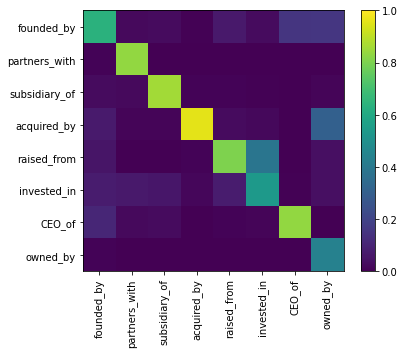

               precision    recall  f1-score   support

   founded_by       0.64      0.92      0.75       700
partners_with       0.84      0.84      0.84        74
subsidiary_of       0.86      0.60      0.70        94
  acquired_by       0.96      0.66      0.78       318
  raised_from       0.81      0.32      0.46       261
  invested_in       0.54      0.62      0.57       265
       CEO_of       0.84      0.53      0.65       245
     owned_by       0.44      0.77      0.56        43

     accuracy                           0.69      2000
    macro avg       0.74      0.66      0.67      2000
 weighted avg       0.74      0.69      0.68      2000



In [ ]:
def print_stat(y, pred, target_names):
    conf_m = confusion_matrix(y, pred)
    print('Confusion matrix:\n', conf_m, '\n')
    plt.figure(figsize=(8/10*conf_m.shape[0], 6/10*conf_m.shape[0]))
    ax = plt.gca()
    im = plt.imshow(conf_m / conf_m.sum(axis=0), vmin=0, vmax=1)
    plt.colorbar(mappable=im, ax=ax)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels([''] + target_names + [''], rotation=90)
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels([''] + target_names + [''])
    plt.show()

    print(classification_report(y, pred, target_names=target_names))


print_stat(test_ids, preds, target_names=list(q_templates.keys()))

> The model performance is quite high, except for `CEO_of` relation, which the model sometimes incorrectly predicts, probably instead of `founded_by` or `owned_by`.